In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from textblob import TextBlob
import spacy
nlp=spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score,recall_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [49]:
def read_data():
    dataset=pd.read_csv('Dataset.csv',
                header=None,
                 names=['Sentiment','News'],
                 encoding="cp1252")
    return dataset

def convert_to_lower_case():
    def lower(input_text):
        return input_text.lower()
    dataset['News']=dataset['News'].apply(lower)
    
def remove_punctuation():
    def remove_punctuation_from_text(input_text):
        output_list=[word for word in input_text.split() if word.isalpha()]
        return ' '.join(output_list)    
    dataset['News']=dataset['News'].apply(remove_punctuation_from_text)

def correct_words():
    def correct_text(input_text):
        list_1=[str(TextBlob(word).correct()) for word in input_text.split()]
        output_text= ' '.join(list_1)
        return output_text
    dataset['News']=dataset['News'].apply(correct_text)
    
def lemmatize():
    def lematize_text(input_text):
        doc=nlp(input_text)
        lemmas=[token.lemma_ for token in doc]
        output_text=' '.join(lemmas)
        return output_text
    dataset['News']=dataset['News'].apply(lematize_text)
    
def remove_stopwords():
    def remove_stopwords_from_text(input_text):
        stopwords=spacy.lang.en.stop_words.STOP_WORDS
        output_list=[word for word in input_text.split() if word not in stopwords and not(word=='-PRON-') ]
        return ' '.join(output_list)
    dataset['News']=dataset['News'].apply(remove_stopwords_from_text)

def split_train_test():
    data = dataset['News'].values.tolist()
    target = dataset['Sentiment'].values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42,stratify=target)
    y_train=np.array(y_train)
    y_test=np.array(y_test)
    return x_train, x_test, y_train, y_test 

In [50]:
#reading the data
dataset=read_data()

dataset.head()

,Sentiment,News
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [51]:
dataset = dataset.replace('positive', 1)
print(dataset.head())

  Sentiment                                               News
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3         1  With the new production plant the company woul...
4         1  According to the company 's updated strategy f...


In [52]:
dataset = dataset.replace('negative', 2)
dataset = dataset.replace('neutral', 0)

In [53]:
print(dataset.head())

   Sentiment                                               News
0          0  According to Gran , the company has no plans t...
1          0  Technopolis plans to develop in stages an area...
2          2  The international electronic industry company ...
3          1  With the new production plant the company woul...
4          1  According to the company 's updated strategy f...


# **Visualizations**

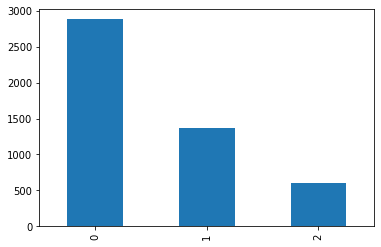

In [54]:
dataset['Sentiment'].value_counts().plot(kind='bar')
plt.show()

In [55]:
neutral_dataframe = dataset[dataset['Sentiment']==0]
positive_dataframe = dataset[dataset['Sentiment']==1]
negative_dataframe = dataset[dataset['Sentiment']==2]
negative_dataframe.head()

,Sentiment,News
2,2,The international electronic industry company ...
415,2,A tinyurl link takes users to a scamming site ...
421,2,"Compared with the FTSE 100 index , which rose ..."
423,2,"Compared with the FTSE 100 index , which rose ..."
500,2,One of the challenges in the oil production in...


# **Pre-Processing**

In [56]:
#Preprocessing the text
convert_to_lower_case()
remove_punctuation()
lemmatize()
remove_stopwords()

#Preparing data for model
print(dataset.head())


   Sentiment                                               News
0          0  accord gran company plan production russia com...
1          0  technopoli plan develop stage area square mete...
2          2  international electronic industry company elco...
3          1  new production plant company increase capacity...
4          1  accord company update strategy year basware ta...


In [57]:
dataset.columns

Index(['Sentiment', 'News'], dtype='object')

In [58]:
x_train, x_test, y_train, y_test =split_train_test()

# **Model Training**

**N-Grams, Decision Tree Classifier**

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df= 5, ngram_range=(1,2)).fit(x_train)

In [60]:
len(vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1936

In [61]:
X_train_vectorized = vect.transform(x_train)

In [ ]:
print(X_train_vectorized)

In [64]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

In [66]:
X_test_vectorized = vect.transform(x_test)

In [68]:
DT_predictions = DT.predict(X_test_vectorized)
DT_score = DT.score(X_test_vectorized, y_test)
print(DT_score)

0.7144329896907217


In [78]:
from sklearn.metrics import classification_report, confusion_matrix

In [79]:
print(classification_report(y_test, DT_predictions))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       576
           1       0.66      0.59      0.62       273
           2       0.55      0.55      0.55       121

    accuracy                           0.71       970
   macro avg       0.66      0.65      0.65       970
weighted avg       0.71      0.71      0.71       970



In [71]:
print(DT_predictions)

[2 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 1 2 2 1 0 1 2 2 0 2 0 0 0 0 1 0 0 1 0 0
 0 1 2 2 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 1
 0 0 0 1 0 0 0 0 1 2 2 1 0 0 0 0 0 1 2 0 0 1 0 0 0 0 2 0 0 1 2 0 2 0 0 2 0
 0 1 1 0 0 0 1 2 0 0 0 2 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 2 2 1 2 0 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 2 1 2 0 1 0 1 0 1 0 0 1 0 0 0 0 2 0 1 0 0 1 1 1 0 0 1 0
 0 1 0 0 0 2 1 1 1 0 2 1 0 0 0 1 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0
 0 0 0 0 0 2 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 2 0 0 1 1
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 0 1 0 1 2 0 0 1 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 2 0 1 0 0 0 0 0 0 1 2 0 2 1 2 1 0 1 0 0 1 2 0 0 0 0 0 1 2 0 0 0 1 0 1
 0 1 1 0 0 0 2 2 2 0 0 0 0 2 0 0 0 0 0 0 1 0 1 0 0 1 1 2 1 0 1 0 2 2 0 2 0
 0 0 0 1 0 1 2 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 2 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 2 0 1 2 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 2 2 0 0 2 1 0 1 0 0
 0 0 1 0 2 0 0 0 0 0 1 1 

In [72]:
print(y_test)

[0 0 0 0 0 0 2 0 0 2 0 0 0 0 1 0 0 1 2 0 1 0 1 0 2 1 0 0 0 0 1 0 0 0 1 0 0
 1 1 1 0 0 2 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 2 0 0 2 0 2 2 1 0 0
 1 0 0 1 0 1 0 1 1 0 2 1 0 1 1 0 0 1 2 0 0 1 0 0 2 0 2 0 0 1 0 0 0 0 0 1 0
 2 1 0 0 0 0 1 2 1 0 1 0 0 2 0 1 1 0 0 0 1 1 0 0 2 2 0 2 2 1 2 0 0 1 0 1 0
 0 1 1 0 0 0 0 0 0 2 0 2 0 1 0 0 1 1 0 0 1 0 0 0 0 2 0 1 1 2 1 1 2 0 1 1 0
 1 1 2 0 0 2 1 0 1 0 2 1 0 0 0 0 0 0 0 0 0 2 0 1 2 1 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 2 0 1 1 0 0 1 0 0 0 2 0 0 0 1 1 1 1 0 2 0 1 1 0 0 1 0 1 0 0 1 0
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 0 1 1 1 2 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 1 1 0 1 1 0 2 1 1 1 0 0 0 0 2 0 0 1 0 0 0
 0 1 2 0 1 0 2 0 1 0 0 1 2 0 0 1 2 1 1 0 0 0 1 2 0 0 0 0 1 1 2 0 0 0 0 0 1
 2 1 1 2 2 1 2 0 2 0 1 0 0 2 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 2 1 0 0 0 1 0 2 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 2
 0 0 1 0 0 0 0 1 0 1 0 2 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 2 2 2
 0 0 1 0 2 0 0 1 1 0 1 1 

**Random Forest Classifier**

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
RFC = RandomForestClassifier(n_estimators = 100)

In [75]:
RFC.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [76]:
RFC_predict = RFC.predict(X_test_vectorized)

In [77]:
RFC_score = RFC.score(X_test_vectorized, y_test)
print(RFC_score)

0.7628865979381443


In [81]:
print(classification_report(y_test, RFC_predict))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       576
           1       0.73      0.57      0.64       273
           2       0.70      0.46      0.56       121

    accuracy                           0.76       970
   macro avg       0.74      0.65      0.68       970
weighted avg       0.76      0.76      0.75       970



**TF-IDF**

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer().fit(x_train)

In [83]:
X_train_vectorized_tfidf = tfidf_vect.transform(x_train)

In [85]:
RFC.fit(X_train_vectorized_tfidf, y_train)

RandomForestClassifier()

In [86]:
RFC_predict = RFC.predict(tfidf_vect.transform(x_test))

In [88]:
RFC_score = RFC.score(tfidf_vect.transform(x_test), y_test)
print(RFC_score)

0.7525773195876289


In [89]:
print(classification_report(y_test, RFC_predict))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       576
           1       0.75      0.50      0.60       273
           2       0.74      0.42      0.54       121

    accuracy                           0.75       970
   macro avg       0.75      0.62      0.66       970
weighted avg       0.75      0.75      0.73       970



In [90]:
DT.fit(X_train_vectorized_tfidf, y_train)

DecisionTreeClassifier()

In [91]:
DT_predict = DT.predict(tfidf_vect.transform(x_test))

In [93]:
DT_score = RFC.score(tfidf_vect.transform(x_test), y_test)
print(DT_score)

0.7525773195876289


In [94]:
print(classification_report(y_test, DT_predict))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       576
           1       0.60      0.58      0.59       273
           2       0.56      0.53      0.54       121

    accuracy                           0.71       970
   macro avg       0.65      0.64      0.64       970
weighted avg       0.70      0.71      0.70       970



**GRU**

In [116]:
num_words=1000 # number of words that we are going to use. 

data = dataset['News'].values.tolist()

tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data)

#tokenization
x_train_tokens=tokenizer.texts_to_sequences(x_train)
x_test_tokens=tokenizer.texts_to_sequences(x_test)


#padding
x_train_pad=pad_sequences(x_train_tokens)
x_test_pad=pad_sequences(x_test_tokens)

In [127]:
x_train_pad.shape

(3876, 28)

In [128]:
model=Sequential()
embedding_size=50  #create a 50 size vector for each word.
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=28,
                    name='embedding_layer')) 

model.add(GRU(units=16,return_sequences=True) )
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [129]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [131]:
model.build(input_shape=(None,28))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_30 (ModuleWr  (None, 28, 50)           50000     
 apper)                                                          
                                                                 
 module_wrapper_31 (ModuleWr  (None, 28, 16)           3216      
 apper)                                                          
                                                                 
 module_wrapper_32 (ModuleWr  (None, 28, 8)            600       
 apper)                                                          
                                                                 
 module_wrapper_33 (ModuleWr  (None, 4)                156       
 apper)                                                          
                                                                 
 module_wrapper_34 (ModuleWr  (None, 3)               

In [132]:
history = model.fit(x_train_pad,
          y_train,
          epochs=5, validation_split=0.2)

Epoch 1/5
97/97 [==============================] - 15s 73ms/step - loss: 0.9066 - accuracy: 0.5948 - val_loss: 0.8054 - val_accuracy: 0.6456
Epoch 2/5
97/97 [==============================] - 6s 64ms/step - loss: 0.7336 - accuracy: 0.6777 - val_loss: 0.7169 - val_accuracy: 0.6856
Epoch 3/5
97/97 [==============================] - 6s 63ms/step - loss: 0.5792 - accuracy: 0.7703 - val_loss: 0.6740 - val_accuracy: 0.7268
Epoch 4/5
97/97 [==============================] - 6s 64ms/step - loss: 0.4706 - accuracy: 0.8277 - val_loss: 0.6652 - val_accuracy: 0.7229
Epoch 5/5
97/97 [==============================] - 6s 64ms/step - loss: 0.4066 - accuracy: 0.8539 - val_loss: 0.6983 - val_accuracy: 0.7062


In [133]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


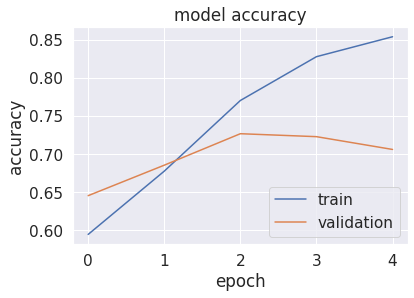

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('accuracy_epoch.png')
plt.show()

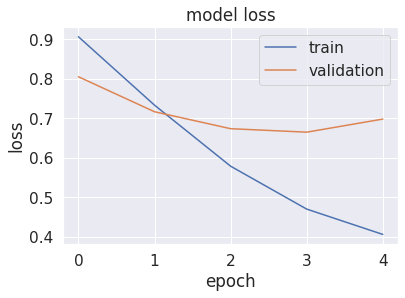

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('loss_epoch.png')
plt.show()